#IRAN Stock Market Prediction using LSTM

In this section, we will introduce how to use LSTM networks for market prediction. The dataset we use is the Goltash price.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [51]:
# Importing Training Set
dataset_train = pd.read_csv('File_FORMATTED.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[3:9]

datelist_train = list(dataset_train['<DTYYYYMMDD>'])
datelist_train = [dt.datetime.strptime(str(date),'%Y%m%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (3481, 9)
All timestamps == 3481
Featured selected: [&#39;&lt;HIGH&gt;&#39;, &#39;&lt;LOW&gt;&#39;, &#39;&lt;CLOSE&gt;&#39;, &#39;&lt;OPEN&gt;&#39;, &#39;&lt;LAST&gt;&#39;, &#39;&lt;VOL&gt;&#39;]


In [52]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (3481, 6).


array([[   4040.,    4000.,    4020.,    4001.,    4020., 1043051.],
       [   4221.,    4221.,    4221.,    4020.,    4221., 2310692.],
       [   4432.,    4432.,    4432.,    4221.,    4432., 1497896.],
       ...,
       [  32930.,   30670.,   31290.,   32280.,   31640.,      nan],
       [  32500.,   30000.,   30900.,   31290.,   30190.,      nan],
       [  30990.,   29360.,   29930.,   30900.,   29870.,      nan]])

In [53]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.58738015],
       [-0.56397588],
       [-0.53669245],
       ...,
       [ 3.14825136],
       [ 3.09265006],
       [ 2.89739898]])

# Creating a data structure with 90 timestamps and 1 output
# Number of days we want top predict into the future is 90
# Number of past days we want to use to predict the future is 60

In [250]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 90   # Number of days we want top predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3332, 60, 5).
y_train shape == (3332, 1).


In [232]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [233]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
 2/11 [====&gt;.........................] - ETA: 44s - loss: 0.4930WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2214s vs `on_train_batch_end` time: 9.6660s). Check your callbacks.
11/11 [==============================] - ETA: 0s - loss: 0.3061
Epoch 00001: val_loss improved from inf to 1.55036, saving model to weights.h5
11/11 [==============================] - 19s 2s/step - loss: 0.3061 - val_loss: 1.5504
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.2370
Epoch 00002: val_loss did not improve from 1.55036
11/11 [==============================] - 3s 305ms/step - loss: 0.2370 - val_loss: 1.7610
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.2153
Epoch 00003: val_loss improved from 1.55036 to 1.39267, saving model to weights.h5
11/11 [==============================] - 4s 375ms/step - loss: 0.2153 - val_loss: 1.3927
Epoch 4/30
11/11 [==============================] - ETA

In [234]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()


# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [235]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [236]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    # x : a given datetime value (datetime.date)
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['<OPEN>']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['<OPEN>']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,<OPEN>
2002-08-18,5883.375977
2002-08-19,5848.064941
2002-08-24,5802.728516


# Prediction Train Data

In [237]:
predictions_train

array([[-0.34902173],
       [-0.3535877 ],
       [-0.3594499 ],
       ...,
       [ 0.02020596],
       [ 0.01923126],
       [ 0.01786958]], dtype=float32)

In [238]:
y_train

array([[-0.33394167],
       [-0.33122625],
       [-0.30743407],
       ...,
       [ 3.14825136],
       [ 3.09265006],
       [ 2.89739898]])

#Ploting from 2001

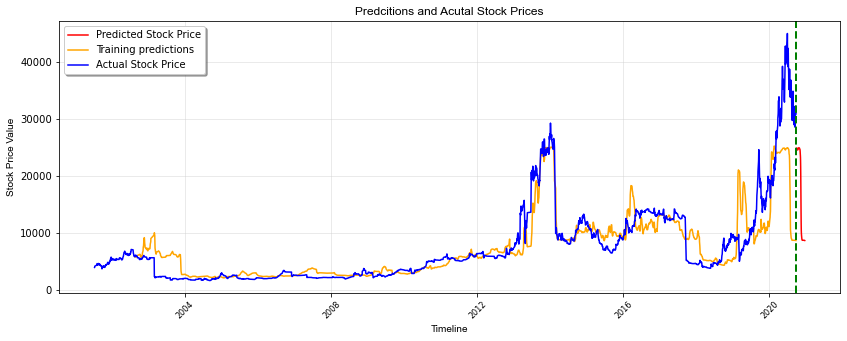

In [239]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2001-01-07'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['<OPEN>'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['<OPEN>'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['<OPEN>'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [240]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

In [ ]:
copy = np.delete(y_train,[range(60)],0)

In [283]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Mean Absolute Error:', mean_absolute_error(copy, predictions_train))
print('Mean Squared Error:', mean_squared_error(copy, predictions_train))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(copy, predictions_train)))
print('R2 Scrore:', r2_score(copy, predictions_train))

Mean Absolute Error: 0.3041943613825069
Mean Squared Error: 0.31919656165415916
Root Mean Squared Error: 0.5649748327617428
R2 Scrore: 0.6963427455406279
